# Functions

### Algorithms

In [1]:
def LASSO( A, d, la_array ):
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding with hot-start.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    num_lam = len(la_array)
    W = np.zeros((n, num_lam))
    w = np.zeros((n,1))
    for i, λ in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*λ/2, 0, np.inf)
            W[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return W

In [2]:
def Ridge( A, d, la_array ):
    cols = A.shape[1]
    I = np.eye(cols)
    W = np.empty((cols,len(la_array)))
    for i, λ in enumerate(la_array):
        w = np.linalg.inv(A.T@A + λ*I)@A.T@d
        w = w[:,0]
        W[:,i] = w # each column is a different w
    return W

In [3]:
def my_SVM( A, d, la_array ):
    rows, cols = A.shape
    max_iter = 3*10**5
    #tol = 0.001
    tau = 1/np.linalg.norm(A,2)**2
    #tau = 1e-7
    tol = 5e-5
    num_rand = 1 # number of random points per iteration
    W = np.zeros((cols, len(la_array)))
    w = np.zeros((cols,1))
    i_k = np.arange(rows).reshape(1,-1) # Full GD
    for k, λ in enumerate(la_array):
        #w = np.zeros((cols,1))
        for j in range(max_iter):
            #i_k = np.random.randint(0,rows,size=(1,num_rand)).reshape(1,-1) # SGD
            dAw = (d[i_k,:]*A[i_k,:]@w).reshape(1,-1)
            i_loss = i_k[dAw < 1]
            sum_subgrad = np.sum((-d[i_loss]*A[i_loss,:]).T,axis=1).reshape(-1,1)
            
            grad = sum_subgrad + 2*λ*w
            w_old = w
            #tau = 1e-4/(j+1)
            w = w - tau*grad
            w = w[:,0]
            if np.linalg.norm(w - w_old) < tol:
                break
        W[:, k] = w
    return W

In [4]:
# Train classifier using linear SVM from SK Learn library
def SVM( A, d, la_array ):
    cols = A.shape[1]
    W = np.zeros((cols, len(la_array)))
    for k, λ in enumerate(la_array):
        clf = LinearSVC( loss='hinge',random_state=0, fit_intercept=True, tol=1e-2, C=1/λ , max_iter=1e5)
        clf.fit(A, np.squeeze(d))
        w_SVM = clf.coef_.T
        W[:,k] = w_SVM[:,0]
    return W

In [5]:
# Neural Network
def NN( A_v, A_t, d_t ):
    rows, cols = A_t.shape
    q = 1 #number of classification problems
    M = 400 #number of hidden nodes
    d_T = np.zeros(( len(d_t), 1 ))
    d_T[ d_t == 1 ] = 1

    ## initial weights
    V = np.random.randn(M+1, q); 
    W = np.random.randn(cols, M);

    alpha = 0.1 #step size
    L = 20 #number of epochs

    def logsig(_x):
        return 1/(1+np.exp(-_x))

    for epoch in range(L):
        ind = np.random.permutation(rows)
        for i in ind:
            # Forward-propagate
            H = logsig(np.hstack((np.ones((1,1)), A_t[[i],:]@W)))
            Yhat = logsig(H@V)
             # Backpropagate
            delta = (Yhat-d_T[[i],:])*Yhat*(1-Yhat)
            Vnew = V-alpha*H.T@delta
            gamma = delta@V[1:,:].T*H[:,1:]*(1-H[:,1:])
            Wnew = W - alpha*A_t[[i],:].T@gamma
            V = Vnew
            W = Wnew
        # print(epoch)
    # Predicted labels on validation data
    H = logsig(np.hstack((np.ones((A_v.shape[0],1)), A_v@W)))
    dhat = 2*logsig(H@V)-1 # has +1/-1 range
    return dhat

### Data Preprocessing

In [6]:
# One-hot encoding
# col_ind -> list of column values (locations of categorical features) 

def one_hot( A, col_indices ):
    notOneHot = np.delete(A, col_indices, axis=1)
    for i, cat_col in enumerate(col_indices):
        for j, uniq in enumerate(np.unique(A[:,cat_col])):
            hot_col = -1*np.ones((A.shape[0],1))
            hot_col[A[:,cat_col] == uniq] = 1
            if j == 0:
                hot_cols = hot_col
            else:
                hot_cols = np.hstack((hot_cols,hot_col))
        if i == 0:
            OneHot = hot_cols
        else:
            OneHot = np.hstack((OneHot,hot_cols))
    A_new = np.hstack((notOneHot,OneHot))
    return A_new

In [7]:
# Feature Scaling
# Normalize the range of the features to -1 and 1
def normalize( A ):
    ones_col = np.ones((A.shape[0],1))
    u = np.mean(A,axis=0).reshape(1,-1)
    u_mat = ones_col@u
    Au = A - u_mat
    std = np.std(A,axis=0).reshape(1,-1)
    std_mat = ones_col@std
    Asc = Au/std_mat
    #ran = (np.max(A,axis=0) - np.min(A,axis=0)).reshape(1,-1)
    #ran_mat = ones_col@ran
    #Asc = Au/ran_mat
    return Asc

In [8]:
# Specify training and validation sets
def training_validation_sets( A, d, ind, i ):
    A_t = np.vstack(( A[int(ind[0]):int(ind[i]),:] , A[int(ind[i+1]):int(ind[-1]),:] )) # training data
    A_v = A[int(ind[i]):int(ind[i+1]),:] # validation data
    d_t = np.vstack(( d[int(ind[0]):int(ind[i]),:] , d[int(ind[i+1]):int(ind[-1]),:] )) # training labels
    d_v = d[int(ind[i]):int(ind[i+1]),:] # validation labels
    return [A_t, A_v, d_t, d_v]

In [9]:
# --- Holdout Indices --- #
# Split the data into 'num_sets' approximately equal sized sets.
def holdout_indices( A, num_set ):
    rows = A.shape[0]
    remainder = rows%num_sets
    set_size = (rows-remainder)/num_sets
    ind = []
    for i in range(num_sets+1):
        if i <= num_sets - remainder:
            ind = np.append(ind,set_size*i)
        else:
            ind = np.append(ind,set_size + 1 + ind[-1])
    return ind

In [10]:
# --- Low rank approximation --- #
def low_rank( A, rank ):
    Ar = np.zeros((A.shape))
    U,s,VT = np.linalg.svd(A,full_matrices=False)
    for i in range(rank):
        Ui = U[:,i].reshape(-1,1)
        VTi = VT[i,:].reshape(1,-1)
        Ar = Ar + s[i]*Ui@VTi
    U,s,VT = np.linalg.svd(Ar,full_matrices=False)
    s = s[np.log10(s) > -1]
    return [Ar, s]

### Error metrics

In [11]:
# Errors
def errors( d_pred, d_test ):
    ers = np.count_nonzero(np.sign(d_pred) - d_test,axis=0)
    return ers

In [12]:
# Error Rate
def error_rate( d_pred, d_test ):
    ers = errors(d_pred,d_test)
    err = (1/len(d_test))*ers
    return err

In [13]:
# Squared Error
def squared_error( d_pred, d_test ):
    sq_er = np.sum((d_pred - d_test)**2,axis=0)
    return sq_er

In [14]:
# Error metrics
def error_metrics( d_pred, d_test ):
    ers = errors( d_pred, d_test )
    err = error_rate( d_pred, d_test )
    sq_er = squared_error( d_pred, d_test )
    return [ers, err, sq_er]

### Misc

In [15]:
def best_weights( W, A_v, d_v ):
    # min weight of weights with most correct classifications
    errors = np.count_nonzero(np.sign(A_v@W) - d_v,axis=0)
    w_best = W[:,errors == np.min(errors)] # pick column with least num of errors
    
    w_norms = LA.norm(w_best,axis=0)
    w_Best = w_best[:,w_norms == np.min(w_norms)]
    w_BEST = w_Best[:,0].reshape(-1,1)
    
    INDEX = np.argwhere((w_BEST == W))
    index = INDEX[0,1]*np.ones((len(w_BEST),1))

    return [w_BEST, index]

# Load Data

In [16]:
import numpy as np
from numpy import linalg as LA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

A_d = np.genfromtxt('../data/cardio_disease.csv',delimiter=';',skip_header=1)
A = A_d[:,0:11]
d = A_d[:,11].reshape(-1,1)
d[d == 0] = -1

#Feature scaling
A = normalize(A)
# one-hot encoding for gender, cholesterol, glucose,
# smoke, alcohol, physical activity
A = one_hot(A,[1,6,7,8,9,10])

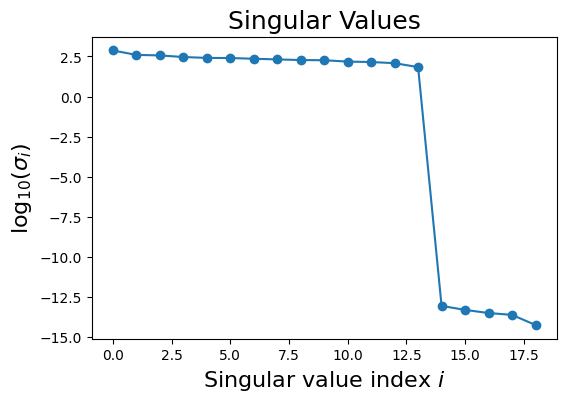

In [195]:
# singular values

U,s,VT = np.linalg.svd(A,full_matrices=False)
fig = plt.figure(figsize=(6,4), dpi= 100)
ax = fig.add_subplot(111)
ax.plot(np.log10(s),'-o')
ax.set_xlabel('Singular value index $i$', fontsize=16)
ax.set_ylabel('$\log_{10}(\sigma_i)$', fontsize=16)
ax.set_title('Singular Values', fontsize=18)
plt.show()

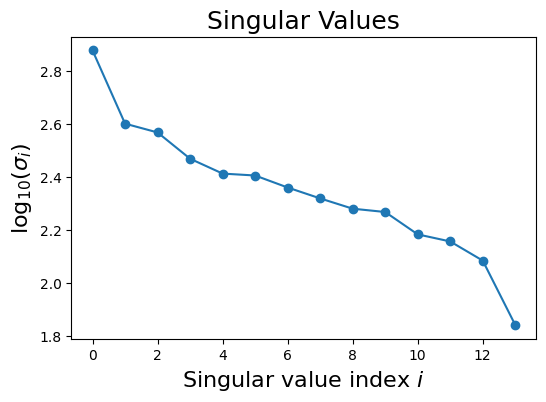

In [210]:
# Low-rank approx of A
rank = 14
Ar, s = low_rank(A, rank)

fig2 = plt.figure(figsize=(6,4), dpi= 100)
ax2 = fig2.add_subplot(111)
ax2.plot(np.log10(s),'o-')
ax2.set_xlabel('Singular value index $i$', fontsize=16)
ax2.set_ylabel('$\log_{10}(\sigma_i)$', fontsize=16)
ax2.set_title('Singular Values', fontsize=18)
plt.show()

In [181]:
num_class = 4 # number of classifiers
num_sets = 10
ind = holdout_indices(Ar,num_sets) # holdout indices
ERS = np.empty((num_sets,num_class))
ERR = np.empty((num_sets,num_class))
SQ_ER = np.empty((num_sets,num_class))
LAMBDA = np.empty((num_sets,3))

#lam_valsRID = np.geomspace(1e-3,1e6,num=100) # logarithmically spaced values
#lam_valsLAS = np.geomspace(1e-3,1e6,num=100)
#lam_valsSVM = np.geomspace(1e-3,1e3,num=100)
lam_valsRID = [8470.50]
lam_valsLAS = [419.20]
lam_valsSVM = [1.060]

for i in range(num_sets):
    print('holdout set: ',i+1)
    A_T, A_V, d_t, d_v = training_validation_sets(Ar,d,ind,i)
    A_t = np.hstack(( np.ones((A_T.shape[0],1)), A_T ))
    A_v = np.hstack(( np.ones((A_V.shape[0],1)), A_V ))
    # Split validation set into two roughly equal sizes
    half = int(np.round(A_v.shape[0]/2))
    A_v1 = A_v[0:half,:]; d_v1 = d_v[0:half,:]
    A_v2 = A_v[half::,:]; d_v2 = d_v[half::,:];
    
    # Best weights, and corresponding indices
    wR, indR = best_weights( Ridge(A_t,d_t,lam_valsRID),A_v1,d_v1 ) # best Ridge regression weights among lam_vals
    wL, indL = best_weights( LASSO(A_t,d_t,lam_valsLAS),A_v1,d_v1 ) # best LASSO weights among lam_vals
    wS, indS = best_weights( SVM(A_t,d_t,lam_valsSVM),A_v1,d_v1 ) # best SVM weights among lam_valsSVM
    d_predNN = NN(A_v2,A_t,d_t) # Neural network predictions
    D_pred = np.hstack(( A_v2@wR, A_v2@wL, A_v2@wS, d_predNN ))

    # Error Metric
    ers, err, sq_er = error_metrics(D_pred,d_v2)
    ERS[i,:] = ers
    ERR[i,:] = err
    SQ_ER[i,:] = sq_er
    
    # Best Lambda Values
    LAMBDA[i,:] = [lam_valsRID[int(indR[0])], lam_valsLAS[int(indL[0])], lam_valsSVM[int(indS[0])]]
print('Done')

holdout set:  1
holdout set:  2
holdout set:  3
holdout set:  4
holdout set:  5
holdout set:  6
holdout set:  7
holdout set:  8
holdout set:  9
holdout set:  10
Done


In [183]:
avg_ers = np.sum(ERS,axis=0)/num_sets
avg_err = np.sum(ERR,axis=0)/num_sets
avg_sqr = np.sum(SQ_ER,axis=0)/num_sets
lambdas  = np.sum(LAMBDA,axis=0)/num_sets

print('Average squared error:')
print('  Ridge: ',avg_sqr[0])
print('  LASSO: ',avg_sqr[1])
print('    SVM: ',avg_sqr[2])
print('     NN: ',avg_sqr[3])
print()

print('Average number of errors:')
print('  Ridge: ',avg_ers[0])
print('  LASSO: ',avg_ers[1])
print('    SVM: ',avg_ers[2])
print('     NN: ',avg_ers[3])
print()

print('Average error rate:')
print('  Ridge: ',avg_err[0])
print('  LASSO: ',avg_err[1])
print('    SVM: ',avg_err[2])
print('     NN: ',avg_err[3])
print()

print('Best Average λ:')
print('  Ridge: ',lambdas[0])
print('  LASSO: ',lambdas[1])
print('    SVM: ',lambdas[2])

Average squared error:
  Ridge:  2669.2107500088186
  LASSO:  2665.0553975521716
    SVM:  5189.803454532448
     NN:  3282.8010674449847

Average number of errors:
  Ridge:  946.6
  LASSO:  945.8
    SVM:  942.7
     NN:  1042.8

Average error rate:
  Ridge:  0.27525443442861297
  LASSO:  0.2750218086653097
    SVM:  0.2741203838325094
     NN:  0.3032276824658331

Best Average λ:
  Ridge:  8470.5
  LASSO:  419.19999999999993
    SVM:  1.0600000000000003
